# TMM Demonstration Using Fabry Perot Etalon
TMM is the foundation of RCWA so we first set up all the infrastructure to do TMM
using scattering matrices

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt;
import cmath;
from TMM_functions import PQ_matrices as pq
from TMM_functions import scatter_matrices as sm
from TMM_functions import redheffer_star as rs
from TMM_functions import generate_initial_conditions as ic
from scipy import linalg as LA


In [4]:
'''
raw TMM formalism using scattering matrices using a single silicon slab (should see Fabry-Perot)
'''

#%% DEFINE SIMULATION PARAMETERS
# TMM CAN FAIL IF KZ = 0 IN ANY MEDIA, which should be unlikely if kz != 0 in incident media

#% General Units
degrees = np.pi/180;
L0 = 1e-6; #units of microns;
eps0 = 8.854e-12;
mu0 = 4*np.pi*10**-7;
c0 = 1/(np.sqrt(mu0*eps0))
I = np.matrix(np.eye(2,2)); #unit 2x2 matrix


## normalized units
#z' = k0*z;
#k = k/k0;

## REFLECTION AND TRANSMSSION SPACE epsilon and mu PARAMETERS
m_r = 1; e_r = 1;
m_t = 1; e_t = 1;

## set wavelength scanning range
wavelengths = L0*np.linspace(1,2,1000); #500 nm to 1000 nm
kmagnitude_scan = 2 * np.pi / wavelengths; #no
omega = c0 * kmagnitude_scan; #using the dispersion wavelengths

thickness_slab = 0.76*L0; #100 nm;
#source parameters
theta = 0 * degrees; #%elevation angle
phi = 0 * degrees; #%azimuthal angle

## incident wave properties, at this point, everything is in units of k_0
n_i = np.sqrt(e_r*m_r);

#k0 = np.sqrt(kx**2+ky**2+kz**2); we know k0, theta, and phi

#actually, in the definitions here, kx = k0*sin(theta)*cos(phi), so kx, ky here are normalized
kx = n_i*np.sin(theta)*np.cos(phi); #constant in ALL LAYERS; kx = 0 for normal incidence
ky = n_i*np.sin(theta)*np.sin(phi); #constant in ALL LAYERS; ky = 0 for normal incidence
kz_inc = cmath.sqrt(e_r * m_r - kx ** 2 - ky ** 2);

normal_vector = np.array([0, 0, -1]) #positive z points down;
ate_vector = np.matrix([0, 1, 0]); #vector for the out of plane E-field
#ampltidue of the te vs tm modes (which are decoupled)
pte = 1/np.sqrt(2);
ptm = cmath.sqrt(-1)/np.sqrt(2);


print('--------incident wave paramters----------------')
print('incident n_i: '+str(n_i))
print('kx_inc: '+str(kx)+' ky_inc: '+str(ky))
print('kz_inc: ' + str(kz_inc));
print('-----------------------------------------------')


## specify gap media
e_h = 1; m_h = 1;
Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
Wg = I; #Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
sqrt_lambda = cmath.sqrt(-1)*Wg;
# remember Vg is really Qg*(Omg)^-1; Vg is the eigenmodes of the H fields
Vg = Qg*Wg*(sqrt_lambda)**-1;

#thickness 0 means L = 0, which only pops up in the xponential part of the expression
ER = [12];
UR = [1];
layer_thicknesses = [thickness_slab, thickness_slab]; #this retains SI unit convention
ref = list(); trans = list();



--------incident wave paramters----------------
incident n_i: 1.0
kx_inc: 0.0 ky_inc: 0.0
kz_inc: (1+0j)
-----------------------------------------------


In [5]:
for i in range(len(wavelengths)): #in SI units
    ## initialize global scattering matrix: should be a 4x4 identity so when we start the redheffer star, we get I*SR

    Sg11 = np.matrix(np.zeros((2, 2)));
    Sg12 = np.matrix(np.eye(2, 2));
    Sg21 = np.matrix(np.eye(2, 2));
    Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
    Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix
    Sg0 = Sg;

    ### ================= Working on the Reflection Side =========== ##
    Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

    ## ============== values to keep track of =======================##
    S_matrices = list();
    kz_storage = [kzr];
    X_storage = list();
    ## ==============================================================##

    # define vacuum wavevector k0
    k0 = kmagnitude_scan[i]; #this is in SI units, it is the normalization constant for the k-vector
    lam0 = wavelengths[i]; #k0 and lam0 are related by 2*pi/lam0 = k0

    ## modes of the layer
    Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
    X_storage.append(Om_r);
    W_ref = I;
    V_ref = Qr * Om_r.I; #can't play games with V like with W because matrices for V are complex

    ## calculating A and B matrices for scattering matrix
    Ar, Br = sm.A_B_matrices(Wg, W_ref, Vg, V_ref);

    S_ref, Sr_dict = sm.S_R(Ar, Br); #scatter matrix for the reflection region
    S_matrices.append(S_ref);
    Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

    Q_storage = list(); P_storage=  list();
    ## go through the layers
    for i in range(len(ER)):
        #ith layer material parameters
        e = ER[i]; m = UR[i];

        #longitudinal k_vector
        P, Q, kzl = pq.P_Q_kz(kx, ky, e, m)
        kz_storage.append(kzl)

        ## E-field modes that can propagate in the medium
        W_i = I;
        ## corresponding H-field modes.
        Om = cmath.sqrt(-1) * kzl * I; X_storage.append(Om)
        V_i = Q * np.linalg.inv(Om);

        #now defIne A and B
        A,B = sm.A_B_matrices(Wg, W_i, Vg, V_i);

        #calculate scattering matrix
        S_layer, Sl_dict = sm.S_layer(A, B, layer_thicknesses[i], k0, Om)
        S_matrices.append(S_layer);

        ## update global scattering matrix using redheffer star
        Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

    ##========= Working on the Transmission Side==============##
    Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);kz_storage.append(kz_trans);

    Om = cmath.sqrt(-1) * kz_trans * I;
    Vt = Qt*np.linalg.inv(Om);

    #get At, Bt
    At, Bt = sm.A_B_matrices(Wg, I, Vg, Vt)

    ST, ST_dict = sm.S_T(At, Bt)
    S_matrices.append(ST);
    #update global scattering matrix
    Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

    K_inc_vector = n_i * k0*np.matrix([np.sin(theta) * np.cos(phi), \
                                    np.sin(theta) * np.sin(phi), np.cos(theta)]);

    # cinc is the c1+
    E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta,  normal_vector, pte, ptm)

    ## COMPUTE FIELDS
    Er = Sg[0:2,0:2]*cinc; #S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
    Et = Sg[2:,0:2]*cinc;  #S21

    Er = np.squeeze(np.asarray(Er));
    Et = np.squeeze(np.asarray(Et));

    Erx = Er[0]; Ery = Er[1];
    Etx = Et[0]; Ety = Et[1];

    # apply the grad(E) = 0 equation to get z components
    Erz = -(kx*Erx+ky*Ery)/kzr;
    Etz = -(kx*Etx+ky*Ety)/kz_trans; ## using divergence of E equation here

    #add in the Erz component to vectors
    Er = np.matrix([Erx, Ery, Erz]); #a vector
    Et = np.matrix([Etx, Ety, Etz]);

    R = np.linalg.norm(Er)**2;
    T = np.linalg.norm(Et)**2;
    ref.append(R);
    trans.append(T);




2.45735958936e-16
2.0


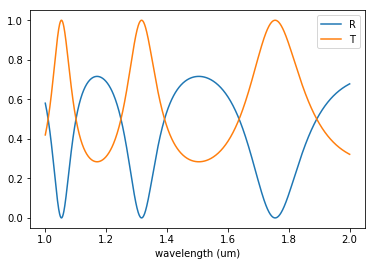

0
2.0
1
2.0
2
2.0
0.0
[[ 0.80+0.19j  0.00+0.j   -0.13+0.55j  0.00+0.j  ]
 [ 0.00+0.j    0.80+0.19j  0.00+0.j   -0.13+0.55j]
 [-0.13+0.55j  0.00+0.j    0.80+0.19j  0.00+0.j  ]
 [ 0.00+0.j   -0.13+0.55j  0.00+0.j    0.80+0.19j]]
[[ 0.80+0.19j  0.00+0.j   -0.13+0.55j  0.00+0.j  ]
 [ 0.00+0.j    0.80+0.19j  0.00+0.j   -0.13+0.55j]
 [-0.13+0.55j  0.00+0.j    0.80+0.19j  0.00+0.j  ]
 [ 0.00+0.j   -0.13+0.55j  0.00+0.j    0.80+0.19j]]


In [6]:
## check that Sg is unitary (medium is lossless)
check = Sg*Sg.I;
print(np.linalg.norm(np.eye(4,4)-check))
#Sg is also supposed to be unitary
print(np.linalg.norm(Sg))

## BASIC PLOTTING
ref = np.array(ref);
trans = np.array(trans)
plt.figure();
plt.plot(wavelengths/L0, ref);
plt.plot(wavelengths/L0, trans);
plt.legend(['R', 'T'])
plt.xlabel('wavelength (um)')
plt.show()

# def fsr(ng, l1, theta, lambda_0):
#     return lambda_0**2/(2*ng*l1*np.cos(theta)+lambda_0)

## calculate global S after the loop
S1 = Sg0;
for i in range(0, len(S_matrices)):
    print(i);
    S1, D,F = rs.RedhefferStar(S1, S_matrices[i]);
    print(np.linalg.norm(S1))

#check that S1 and Sg match
print(np.linalg.norm(S1-Sg))
np.set_printoptions(precision=2)
print(S1)
print(Sg)


## Comparison with Analytic Expression

In [7]:
def Fabry_Perot_Spectra(wavelengths, e_r, slab_thickness):
    '''
    no need for a lattice constant
    :param wavelengths SI units of meters:
    :param e_r (usually between 1 and 12)
    :param slab_thickness SI units of meters:

    :return:
    '''
    degrees = np.pi / 180;
    eps0 = 8.854e-12;
    mu0 = 4 * np.pi *1e-7;
    ## reflection and transmission materials
    Z_1 = np.sqrt(mu0/eps0); #incident
    Z_3 = np.sqrt(mu0/eps0); #transmission
    # slab specifications
    l1 = slab_thickness;
    Z_2 = np.sqrt(mu0/eps0)*(1/e_r**0.5); #medium impedance

    ## define intermediate variables for impedance transform

    im = cmath.sqrt(-1);
    ref = list();
    trans = list()
    ## specify wavelength range to do plotting

    for lam0 in wavelengths:
        kz = (e_r)**0.5*2*np.pi/lam0; #assuming normal incidence
        Zd = Z_2*(Z_3 - im*Z_2*np.tan(kz*l1))/(Z_2 - im*Z_3*np.tan(kz*l1))
        r = (Zd - Z_1)/(Zd+Z_1);
        ref.append(abs(r)**2);
        trans.append(1-abs(r)**2);

    return ref, trans





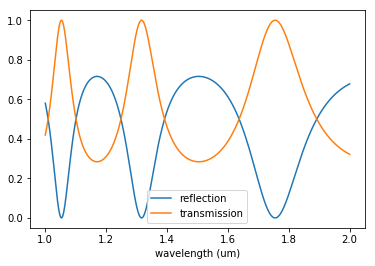

In [8]:
wavelengths = 1e-6*np.linspace(1, 2,1000)
slab_thickness = 0.76*1e-6;
e_r = 12;
theta = 0;

ref, trans = Fabry_Perot_Spectra(wavelengths, e_r, slab_thickness)

plt.figure()
plt.plot(wavelengths*1e6, ref);
plt.plot(wavelengths*1e6, trans);
plt.xlabel('wavelength (um)')
plt.legend(('reflection', 'transmission'))
plt.show()